In [ ]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv
import networkx as nx

# https://biopython.org/docs/1.74/api/Bio.SVDSuperimposer.html
# conda install conda-forge::biopython
from Bio.SVDSuperimposer import SVDSuperimposer
from tqdm import tqdm

# from numpy import dot
from filament import *
from voxelizer import *

# # Path: pymdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
# import pymdna as mdna
import sys
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 

%load_ext autoreload
%autoreload 2

joblib is not installed. Falling back to sequential computation.


In [2]:
# Load H-NS s1s1 dimers
loc_dimers = '/Users/thor/surfdrive/Data/h-ns/dimer/0_s1s1/drytrajs/'
short_trajs = [md.load(loc_dimers+f'dry_{i}.xtc',top=loc_dimers+f'dry_{i}.pdb').remove_solvent() for i in range(0,2)]
# start_open = md.load(loc_dimers+f'dry_open.xtc',top=loc_dimers+f'dry_open.pdb').remove_solvent()
# start_closed = md.load(loc_dimers+f'dry_closed.xtc',top=loc_dimers+f'dry_closed.pdb').remove_solvent()
# s1s1 = md.join([start_open,start_closed,md.join(short_trajs)])
s1s1 = md.join(short_trajs)

# Load H-NS s2s2 dimers
loc_dimers = '/Users/thor/surfdrive/Data/h-ns/dimer/1_s2s2/drytrajs/'
short_trajs = [md.load(loc_dimers+f'dry_{i}.xtc',top=loc_dimers+f'dry_{i}.pdb').remove_solvent() for i in range(0,2)]
s2s2 = md.join(short_trajs)

# Load H-NS dbd to DNA complex
loc_dbd  = '/Users/thor/surfdrive/Data/h-ns/NAR/md/0_highaff/FI/drytrajs/'
traj = [md.load(loc_dbd+f'dry_{i}.xtc',top=loc_dbd+f'dry_{i}.pdb').remove_solvent() for i in range(0,2)]
dna_complex = md.join(traj)

In [3]:
# Define segments of the protein
n = 2 # Overlap of residues between segments

segments = {'s1':np.arange(0,41+n),
            'h3':np.arange(41-n,53+n),
            's2':np.arange(53-n,82+n),
            'l2':np.arange(82-n,95+n),
            'dbd':np.arange(95-n,137)}

# Site map contains a dictionary with the (sub)trajectories of different sites of the protein catergorized from the s1s1 and s2s2 dimers
mapper = SiteMapper(s1s1, s2s2, segments=segments, k=100)
site_map = mapper.get_site_map()
site_map['complex'] = dna_complex


#  Paramers to make filament
n_dimers = 1
chains_to_dna = [0,1]#,3,5] #list(range(0,n_dimers*2))
save = True

# Initialize class to assemble the filament
assembler = Assembler(site_map=site_map)

# Add dimers
print(f'Assembling {n_dimers} H-NS dimers:')
for idx in tqdm(range(n_dimers)):
    assembler.add_dimer(segment='fixed',verbose=True)  

# Add DNA oligo's
n_dna = len(chains_to_dna)
if n_dna > 0:
    print(f"Assembling {n_dna} DNA oligo's:")
    for chainid in tqdm(chains_to_dna):
        assembler.add_dna(chainid=chainid)

# Retrive the trajectory object
traj = assembler.get_traj()

# Store structure as pdb
if save:
    traj.save(f'./pdbs/0_dimer_{assembler.n_dimers}_{assembler.n_dna}.pdb')                

Assembling 1 H-NS dimers:


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Assembling 2 DNA oligo's:


100%|██████████| 2/2 [00:00<00:00,  7.41it/s]


In [4]:
V = Voxelizer(traj.xyz[0],n=30)
dna_a = traj.top.select('chainid 2 3')
dna_b = traj.top.select('chainid 4 5')

points = np.array([md.compute_center_of_mass(traj.atom_slice(dna_a))[0],md.compute_center_of_mass(traj.atom_slice(dna_b))[0]])
V.process_points(points)

Point [23 20 24] is inside voxel space. Moving to nearest zero voxel.
Point [23 20 24], 21324 is nearest zero voxel (22, 20, 24), 20424
Point [ 4 16  5] is inside voxel space. Moving to nearest zero voxel.
Point [ 4 16  5], 4085 is nearest zero voxel (4, 16, 6), 4086


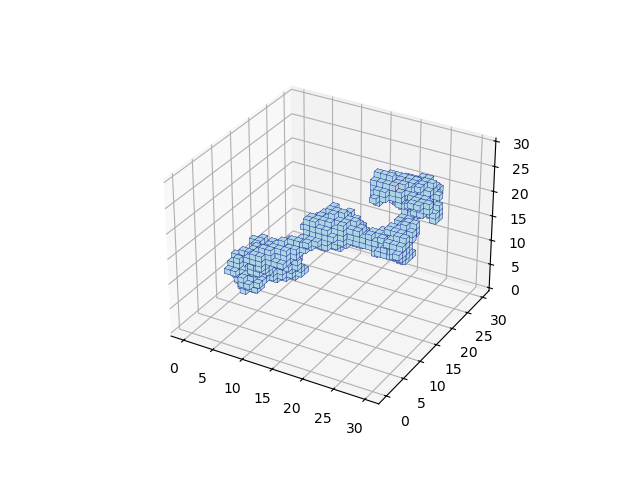

In [5]:
%matplotlib ipympl
V.plot(control_points=True)

In [7]:
def get_COM_selections(traj, QGR_resids):
    coms = []
    for ids in QGR_resids:
        selection = traj.top.select(f'resid {ids[0]} {ids[1]} {ids[2]}')
        com = md.compute_center_of_mass(traj.atom_slice(selection))
        coms.append(com)
    return np.array([list(l) for l in list(np.array(coms).swapaxes(0,1)[0])])


atom_indices = traj.top.select('resSeq 111 112 113')
QGR = []
for index in atom_indices:
    at = traj.top.atom(index)
    res = at.residue
    QGR.append(res.index)

QGR = np.unique(QGR)
QGR_chunks = np.array([QGR[i:i + 3] for i in range(0, len(QGR), 3)])
QGR_chunks = QGR_chunks[chains_to_dna]
QGR_chunks = [QGR_chunks[0],QGR_chunks[1],QGR_chunks[3]]

V = Voxelizer(traj.xyz[0],n=40)
coms = get_COM_selections(traj, QGR_chunks)
V.process_points(points=np.array(coms))
path = V.find_path(ordered=False)

IndexError: index 3 is out of bounds for axis 0 with size 2

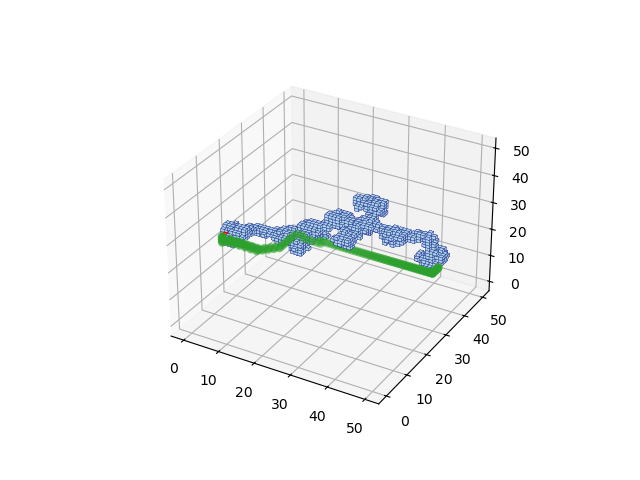

In [ ]:
%matplotlib ipympl
V.plot(path=np.array(path),control_points=True)

In [ ]:
V.control_points

array([[48, 34, 17],
       [13, 31, 17],
       [ 1, 13, 24]])

(-10.857769870758055,
 24.003039264678954,
 -10.661148661375044,
 24.199660474061965,
 -14.144833135604857,
 12.0007737159729)

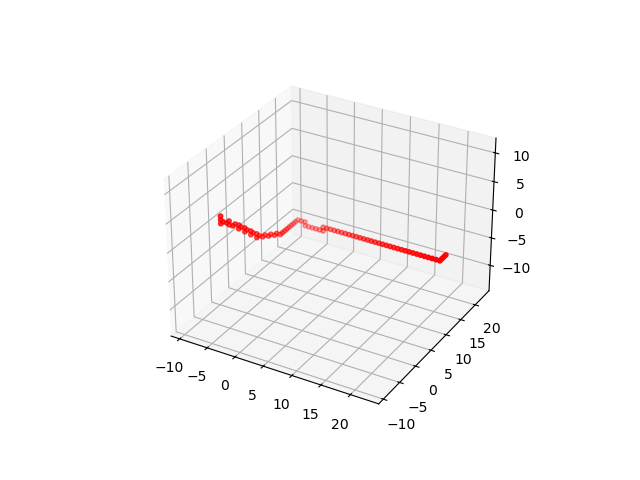

In [ ]:
path_xyz = V.voxel_to_xyz(path)
fig = plt.figure()  
ax = fig.add_subplot(projection='3d')
ax.scatter3D(path_xyz[:,0], path_xyz[:,1], path_xyz[:,2], c='r', s=10)
# ax.scatter3D(coms[:,0], coms[:,1], coms[:,2], c='b', s=100)
# ax.scatter3D(traj.xyz[0,:,0], traj.xyz[0,:,1], traj.xyz[0,:,2], c='g', s=1)
ax.axis('equal')

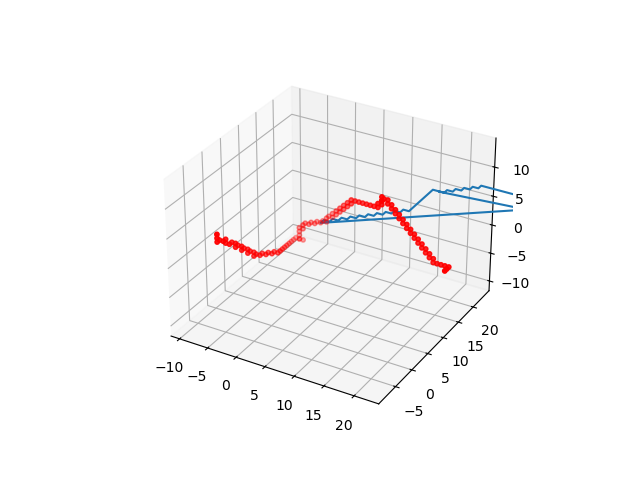

In [ ]:
path = np.array(path)
plt.plot(path.T[0],path.T[1])
plt.show()

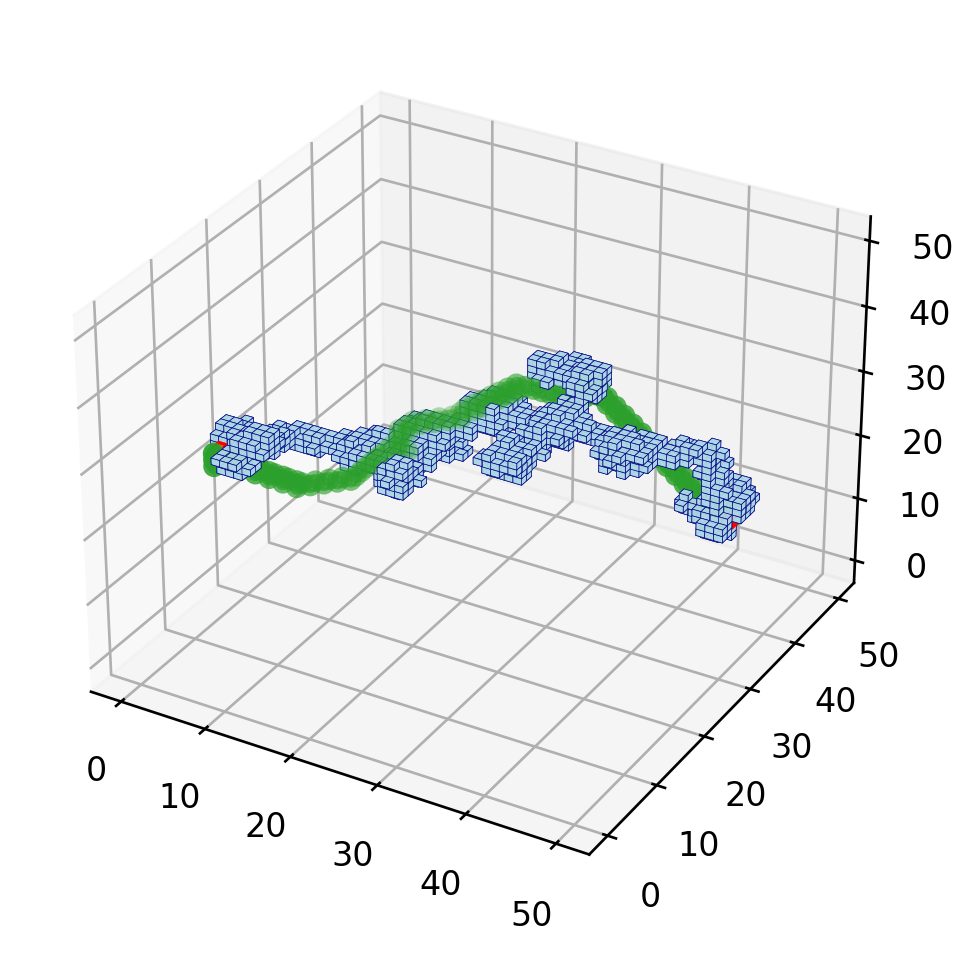

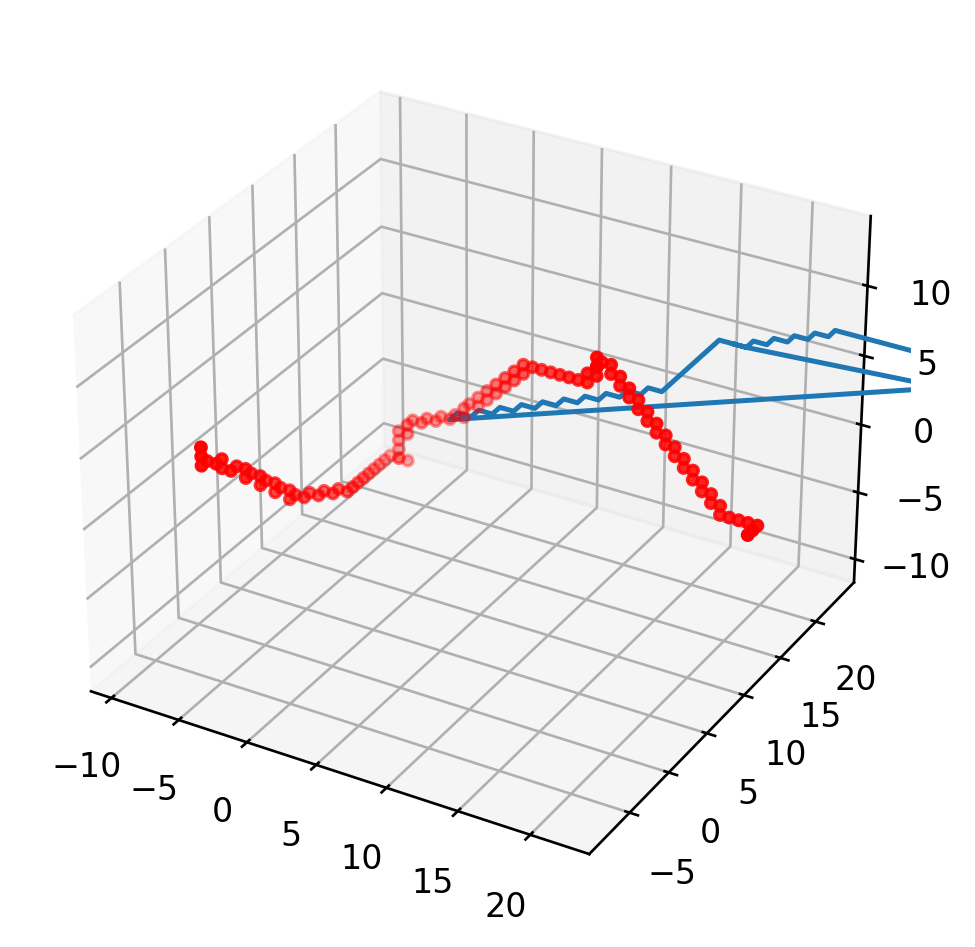

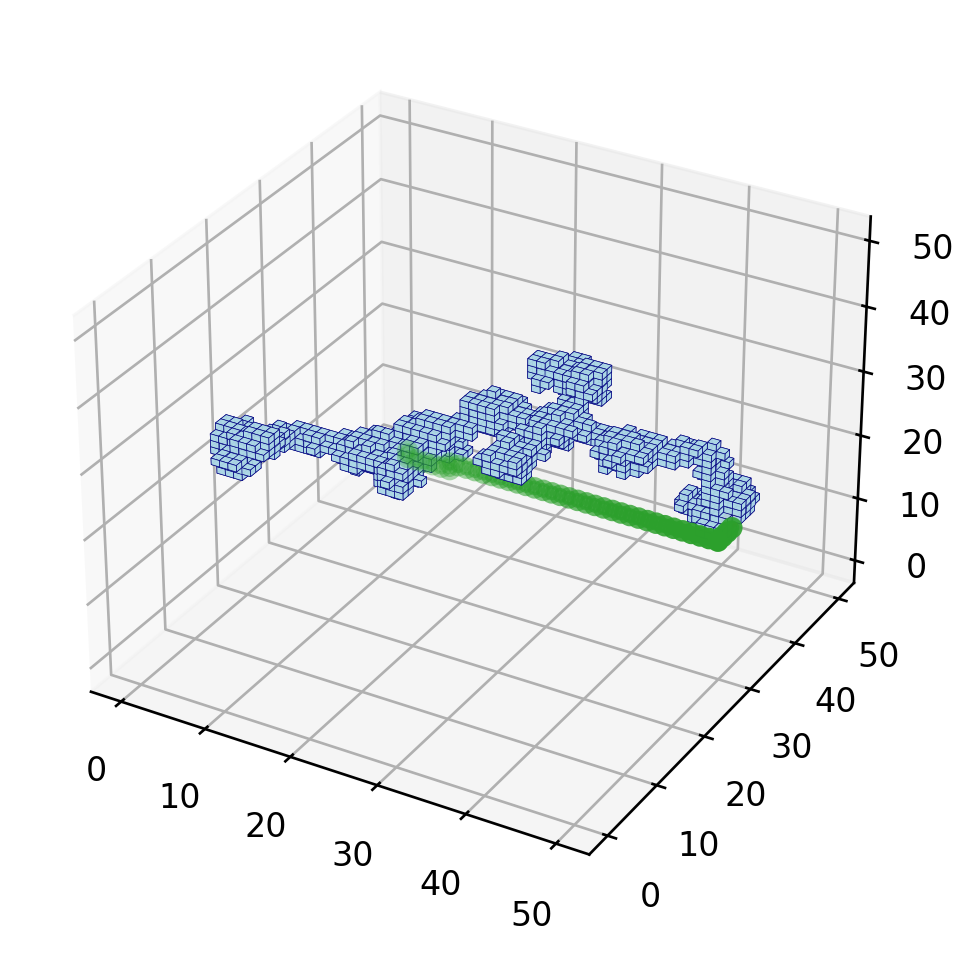

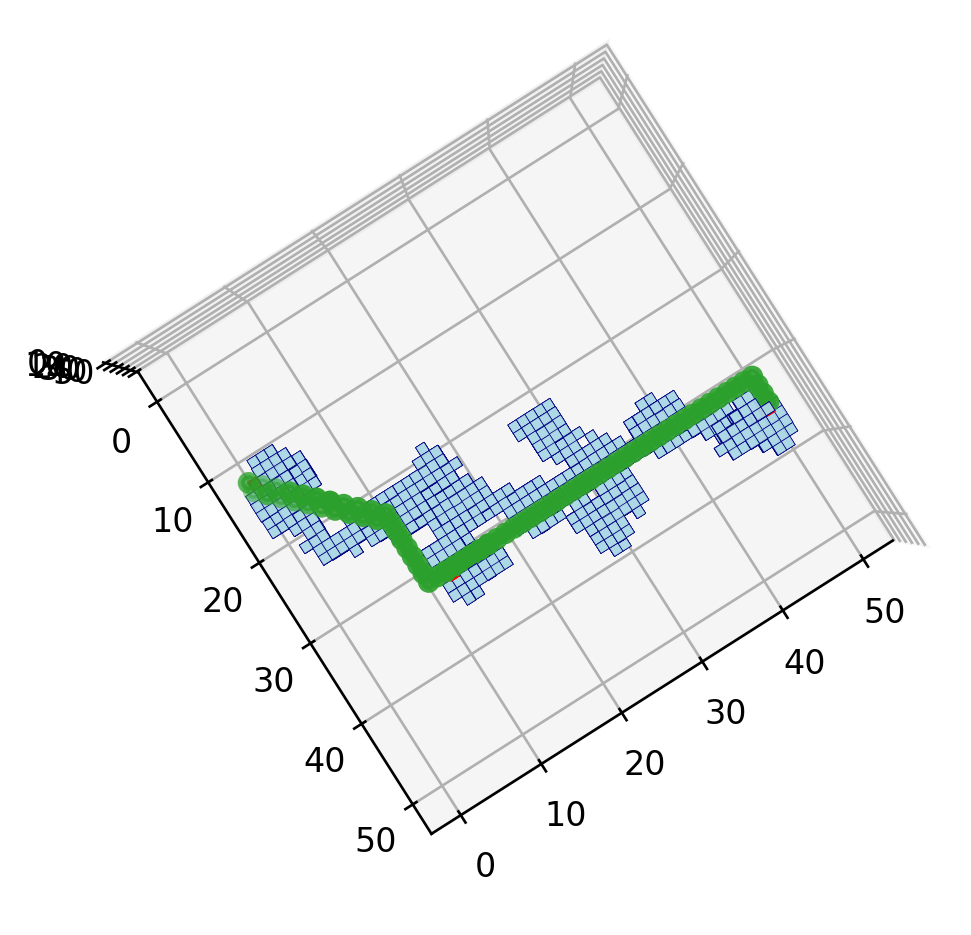

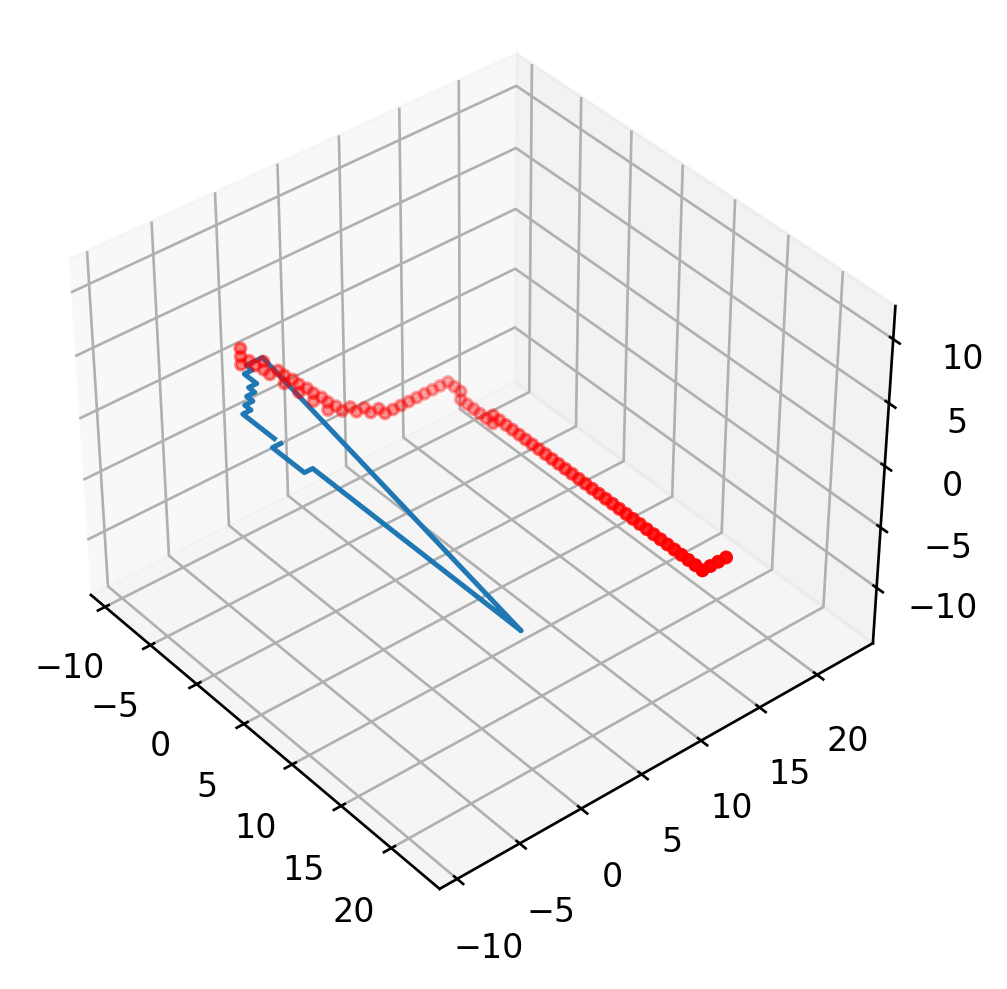

In [ ]:
%matplotlib inline
plt.plot(path_xyz.T[0],path_xyz.T[2])
plt.show()

In [ ]:
import numpy as np
from scipy.signal import savgol_filter

# Assuming path_xyz is a numpy array of shape (n, 3)
smooth_path_xyz = savgol_filter(path_xyz, window_length=20, polyorder=3, axis=0)


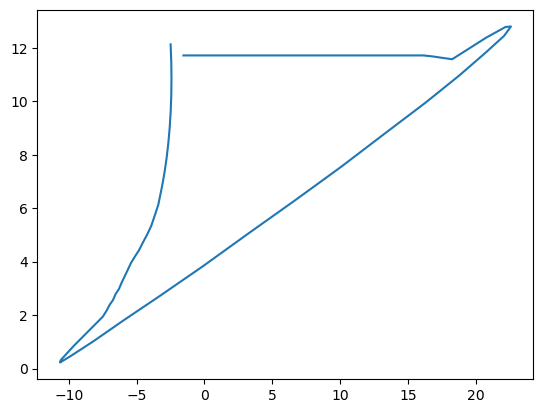

In [ ]:
plt.plot(smooth_path_xyz.T[0],smooth_path_xyz.T[1])

In [ ]:
# Convert the control points to a spline
spline = mdna.SplineFrames(smooth_path_xyz)#,closed=False)
# Generate the DNA structure
generator = mdna.StructureGenerator(sequence=None,spline=spline)#,circular=False)

# Edit the DNA structure to make it compatible with the AMBER force field
dna = generator.traj

AATATATAGTCCACCTATCACCTCGTGACCCAAGTGTCGGTGATTACCGAGGGTCAAAAAGAGACGAAAGGGTTTAAGTTAAATGCGCCGCTCTAATCTAATCTGTTTTCTCCACGCTGGGAATCCGGATGCAACCACTACTGCCCGACATGTGGCGAGGACTAAACTTACCTGAGGAGTCGGCTCAAGATGGGGCGACCTTATTATTGACGTATCAACTTTGGTAATCAGCCAATGCTTCCTGGAAGTACCGGCTTAGTGGAGATTGCAAACACTAACTCGGC


In [ ]:
final = traj.stack(dna)
final.save('./pdbs/1_wow.pdb')

In [ ]:
dna.save('0_dna.pdb')

In [ ]:
path = np.array([[0,0,0],[2,1,3],[3,2,4],[1,3,7]])*3
# Convert the control points to a spline
spline = mdna.SplineFrames(path)#,closed=False)
# Generate the DNA structure
generator = mdna.StructureGenerator(sequence=None,spline=spline)#,circular=False)

# Edit the DNA structure to make it compatible with the AMBER force field
dna = generator.traj

CGTGTCTAAGCTCGGAGTGGAACTGCCAATTACTATGCATCGTCGTGAAGGTCCAGCCGTACATAGGCGCGAATCGGTCCCTGACTGAA


In [ ]:
dna.save('0_dna.pdb')